In [1]:
using QuantumAnnealingTools
# This package is needed to load actual ODE solvers. Without it, the ODE solvers won't work.
using DifferentialEquations
# We need to plot our results for the demo
using Plots

┌ Info: Recompiling stale cache file C:\Users\chenh\.julia\compiled\v1.1\QuantumAnnealingTools\iRrSZ.ji for QuantumAnnealingTools [e429f160-8886-11e9-20cb-0dbe84e78965]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file C:\Users\chenh\.julia\compiled\v1.1\DifferentialEquations\UQdwS.ji for DifferentialEquations [0c46a032-eb83-5123-abaf-570d42b7fbaa]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file C:\Users\chenh\.julia\compiled\v1.1\Plots\ld3vC.ji for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1184


# Single Qubit Example

In this example, we will try to recreate the example in this paper: [Decoherence in adiabatic quantum computation](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.91.062320).
The Hamiltonian is
\begin{equation}
H(s) = -\frac{1}{2}(1-s)\sigma_x - \frac{1}{2}s\sigma_z
\end{equation}

In [2]:
H = DenseHamiltonian([(s)->1-s, (s)->s], -[σx, σz]/2)

DenseHamiltonian with Complex{Float64}
with size: (2, 2)

We can look at its spectrum by

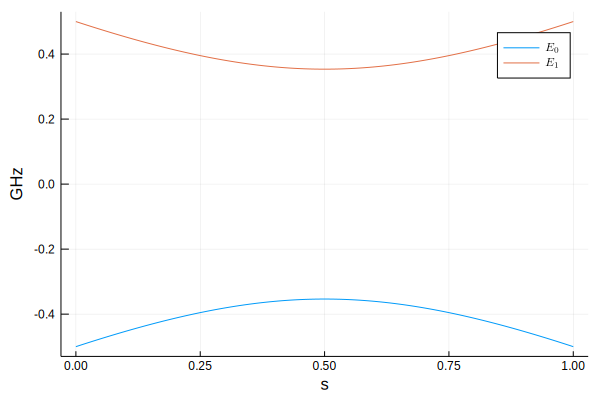

In [3]:
plot(H, 0:0.01:1, 2)

## Unit ($h$ or $\hbar$)
Internally the package work with $h=1$

In [4]:
evaluate(H, 0.5)

2×2 Array{Complex{Float64},2}:
 -0.25+0.0im  -0.25+0.0im
 -0.25+0.0im   0.25+0.0im

If you call the object directly, the result will be scaled by a $2\pi$ factor

In [5]:
H(0.5)

2×2 Array{Complex{Float64},2}:
 -1.5708+0.0im  -1.5708+0.0im
 -1.5708+0.0im   1.5708+0.0im

## Annealing
The total Hamiltonian is
\begin{equation}
    H(s) = H_{\mathrm{S}}(s) + gS \otimes B + H_{\mathrm{B}}
\end{equation}
We denote $S$ the coupling and $\{gB, H_{\mathrm{B}}\}$ the bath.
### Coupling
Like the case of Hamiltonian, we will absorb the additional $2\pi$ factor into $S$. The simplest way to create a coupling term is to use a list of matrices.

In [6]:
coupling = [2π*σz]

1-element Array{Array{Complex{Float64},2},1}:
 [6.28319+0.0im 0.0+0.0im; 0.0+0.0im -6.28319+0.0im]

A dedicate `Coupling` interface will be implemented in the future to support time dependent coupling operator and to hide the $2\pi$ factor.

### Bath
A bath instance can be any object which implement three methods:
  1. Correlation function: `correlation(τ, bath)`
  2. Spectrum density: `γ(ω, bath)`
  3. Lamb shift: `S(ω, bath)`

Those three methods are required by Redfield/Adiabatic ME solvers. Currently we have built in support for Ohmic bath.
An Ohmic bath object can be created by

In [7]:
η = 1e-4
fc = 4
T = 16
bath = Ohmic(η, fc, T)

Ohmic bath instance:
η (unitless): 0.0001
ωc (GHz): 4.0
T (mK): 16.0

In [8]:
info_freq(bath)

ωc (GHz): 4.0
T (GHz): 0.33338579560200365


We can also directly plot the spectrum density of Ohmic bath

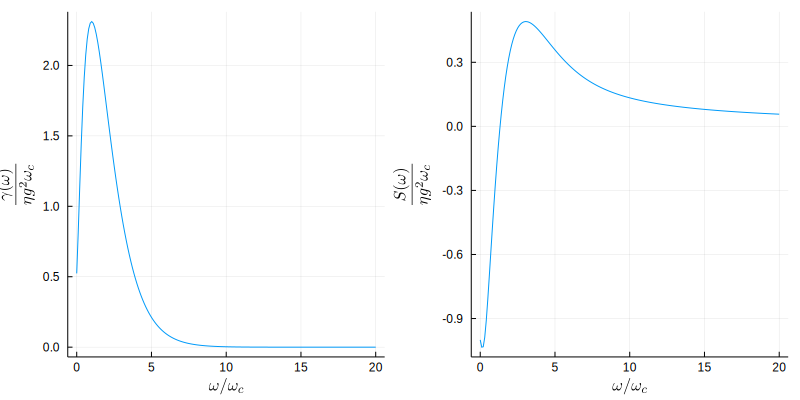

In [9]:
p1 = plot(bath, :γ, range(0,20,length=200), label="", size=(800, 400))
p2 = plot(bath, :S, range(0,20,length=200), label="", size=(800, 400))
plot(p1, p2, layout=(1,2))

### Annealing

Finally, we can assemble the annealing object by

In [10]:
# Hamiltonian
H = DenseHamiltonian([(s)->1-s, (s)->s], -[σx, σz]/4/π)
# initial state
u0 = PauliVec[1][1]
# coupling
coupling = [σz]
# bath
bath = Ohmic(1e-4, 4, 16)
annealing = Annealing(H, u0; coupling=coupling, bath=bath)

Annealing with hType DenseHamiltonian{Complex{Float64}} and uType Array{Complex{Float64},1}
s parameter span: (0.0, 1.0)
u0: Complex{Float64}[0.707107+0.0im, 0.707107+0.0im]
bath: OhmicBath(0.0001, 25.132741228718345, 0.4773896944364562)

Because we want to compare our results to the [reference paper](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.91.062320), which set $\hbar=1$, we scaled down the Hamiltonian by $2\pi$.

## Solvers
Currently there are several interface to the solvers which might be handy

In [11]:
@time sol = solve_schrodinger(annealing, 10*sqrt(2), alg=Tsit5(), abstol=1e-8, retol=1e-8);

  6.793720 seconds (29.27 M allocations: 1.440 GiB, 9.57% gc time)


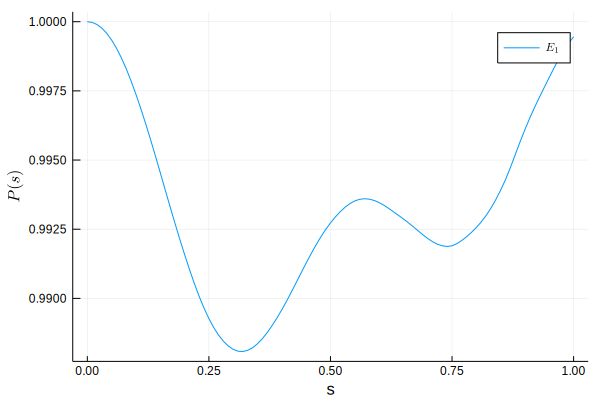

In [12]:
plot(sol, H, [1], 0:0.01:1)

The solution is an ODESolution object in `DifferentialEquations.jl` package. More details for the interface can be found [here](http://docs.juliadiffeq.org/latest/basics/solution.html).

In [13]:
sol(0.5)

2-element Array{Complex{Float64},1}:
 -0.9060832234038826 + 0.18896473228775126im
  -0.341161999249554 + 0.16407507826342396im

other interface includes

In [ ]:
# You need to solve the unitary first before trying to solve Redfield equation
@time U = solve_unitary(annealing, 10*sqrt(2), alg=Tsit5(), abstol=1e-8, retol=1e-8);
@time solve_von_neumann(annealing, 10*sqrt(2), alg=Tsit5(), abstol=1e-8, retol=1e-8);

### Open System
#### Time dependent Redfield Equation
The time depedent Redfield equation interface needs
  1. Annealing object
  2. Total annealing time
  3. Pre-calculated unitary
  
All the other keyword arguments in [solver options](http://docs.juliadiffeq.org/latest/basics/common_solver_opts.html) are supported. Currently, support for implicit methods are only for `solve_schrodinger`.

In [14]:
tf = 10*sqrt(2)
U = solve_unitary(annealing, tf, alg=Tsit5(), abstol=1e-8, retol=1e-8);
sol = solve_redfield(annealing, tf, U; alg=Tsit5(), abstol=1e-8, retol=1e-8);

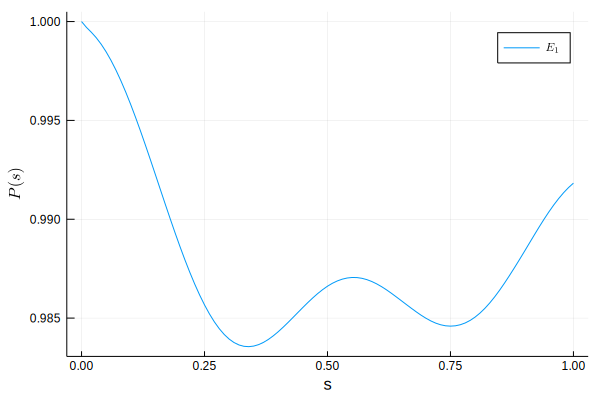

In [15]:
plot(sol, H, [1], 0:0.01:1)

#### Adiabatic Master Equation
The adiabatic master equation interface needs
  1. Annealing object
  2. Total Annealing time

Besides other keyword arguments supported in `DifferentialEquations`, it is highly recommended to add the `ω_hint` keyword argument. By doing this, the solver will pre-compute the lamb shift $S(\omega)$ within given range to speed up the computation.

In [16]:
tf = 10*sqrt(2)
@time sol = solve_davies(annealing, tf; alg=Tsit5(), ω_hint=range(-6, 6, length=100), reltol=1e-8, abstol=1e-8);

  6.508573 seconds (25.13 M allocations: 1.221 GiB, 8.58% gc time)


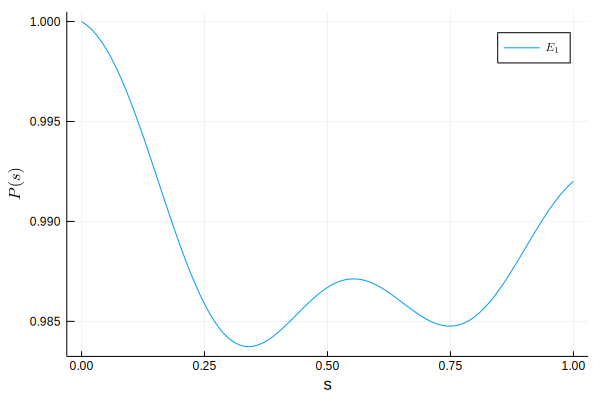

In [17]:
plot(sol, H, [1], 0:0.01:1)

In [18]:
tf = 5000
@time sol = solve_davies(annealing, tf; alg=Tsit5(), ω_hint=range(-6, 6, length=100), reltol=1e-8, abstol=1e-8);

  0.233264 seconds (2.77 M allocations: 178.008 MiB, 13.84% gc time)


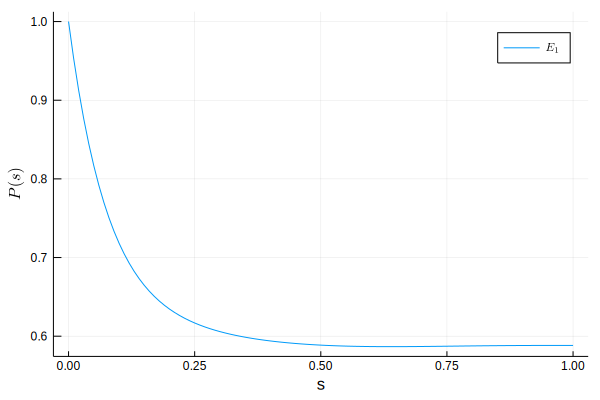

In [19]:
plot(sol, H, [1], 0:0.01:1)

The above results agree with Fig 2 of the [reference paper](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.91.062320).